In [1]:
import sys
from pathlib import Path
APP_PATH = str((Path.cwd().parent / 'app').resolve())

if APP_PATH not in sys.path:
    sys.path.append(APP_PATH)
    
%load_ext autoreload
%autoreload 2

In [2]:
from src.data import load_sessions
from src.selectors import get_selectors

DATA_DIR = Path.cwd().parent / 'data'

sessions = load_sessions(DATA_DIR, cleanup=False)
selectors = [get_selectors(session) for session in sessions]

Loading /home/jovyan/work/data/steinmetz_part0.npz...
Loading /home/jovyan/work/data/steinmetz_part1.npz...
Loading /home/jovyan/work/data/steinmetz_part2.npz...


In [20]:
import numpy as np

DECODER_SESSION = 10
SESSION = sessions[DECODER_SESSION]
SELECTOR = selectors[DECODER_SESSION]

CHOSEN_TRIALS = ~SELECTOR["STIM_RIGHT_NONE"]
num_no_stim = CHOSEN_TRIALS.sum() // 3
no_stim_trials = ~CHOSEN_TRIALS
cutoff_index = np.where(no_stim_trials.cumsum() > num_no_stim)[0][0]
no_stim_trials[cutoff_index:] = False
CHOSEN_TRIALS |= no_stim_trials

In [25]:
from sklearn.preprocessing import LabelEncoder

CLASS_NAMES = ["None", "Low", "Medium", "High"]
NUM_CLASSES = len(CLASS_NAMES)
classes = SESSION['contrast_right'][CHOSEN_TRIALS]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(classes)

# Histogram-based Classifier

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from src.data import get_spikes

X_hist = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    CHOSEN_TRIALS,
    (0, 50),
    align=50,
    baseline_bins=None,
    smoothing=(17, 2.5),
)
X_hist = X_hist.sum(axis=2).T
y_hist = labels

hist_clf = LogisticRegression(penalty='l2', multi_class='ovr', solver='saga', max_iter=10000)
scores = cross_val_score(hist_clf, X_hist, y_hist, cv=5, n_jobs=-1)
print(scores)
print(scores.mean())

[0.48888889 0.53333333 0.42222222 0.55555556 0.42222222]
0.4844444444444444


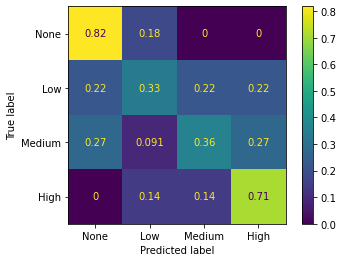

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(
    X_hist,
    y_hist,
    test_size=0.2,
    shuffle=True,
    stratify=y_hist
)
hist_clf.fit(X_train, y_train)
plot_confusion_matrix(hist_clf, X_test, y_test, display_labels=CLASS_NAMES, normalize='true')

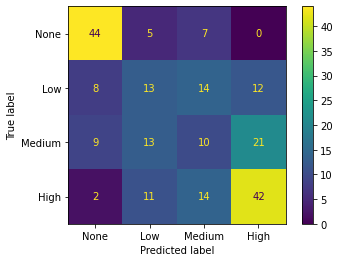

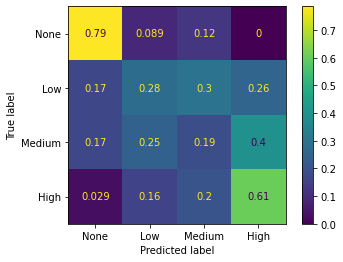

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

y_pred = cross_val_predict(hist_clf, X_hist, y_hist, cv=5, n_jobs=-1)
perf = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=int)
for i in range(len(y_pred)):
    perf[y_hist[i], y_pred[i]] += 1
    
ConfusionMatrixDisplay(perf, display_labels=CLASS_NAMES).plot()
ConfusionMatrixDisplay(perf / perf.sum(axis=1, keepdims=True), display_labels=CLASS_NAMES).plot()

# LDA Classifier

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from src.data import reshape_by_bins

X_lda = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    SELECTOR["CHOICE_CORRECT"],
    (0, 50),
    align=50,
    baseline_bins=None,
    smoothing=None,
)
NUM_BINS_LDA = X_lda.shape[2]
X_lda = reshape_by_bins(X_lda)
y_lda = label_encoder.transform(np.repeat(SESSION['contrast_right'][SELECTOR["CHOICE_CORRECT"]], NUM_BINS_LDA))

lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=3)
lda.fit(X_lda, y_lda)
print(lda.explained_variance_ratio_)

[0.03288875 0.03288868 0.03288868]


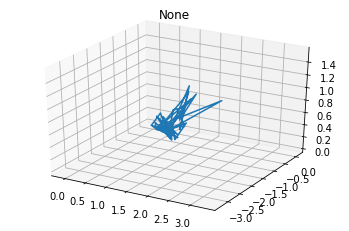

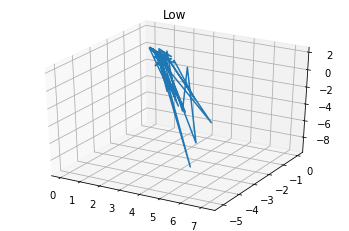

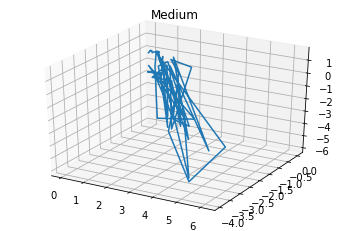

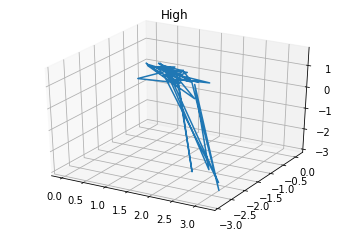

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, class_name in enumerate(CLASS_NAMES):
    trial_num = np.argmax(classes == label_encoder.inverse_transform([i])[0])
    transformed = lda.transform(X_lda[trial_num*NUM_BINS_LDA:(trial_num+1)*NUM_BINS_LDA])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(transformed[:, 0], transformed[:, 1], transformed[:, 2])
    ax.set_title(class_name)

# Contrast-level Linear Regressor

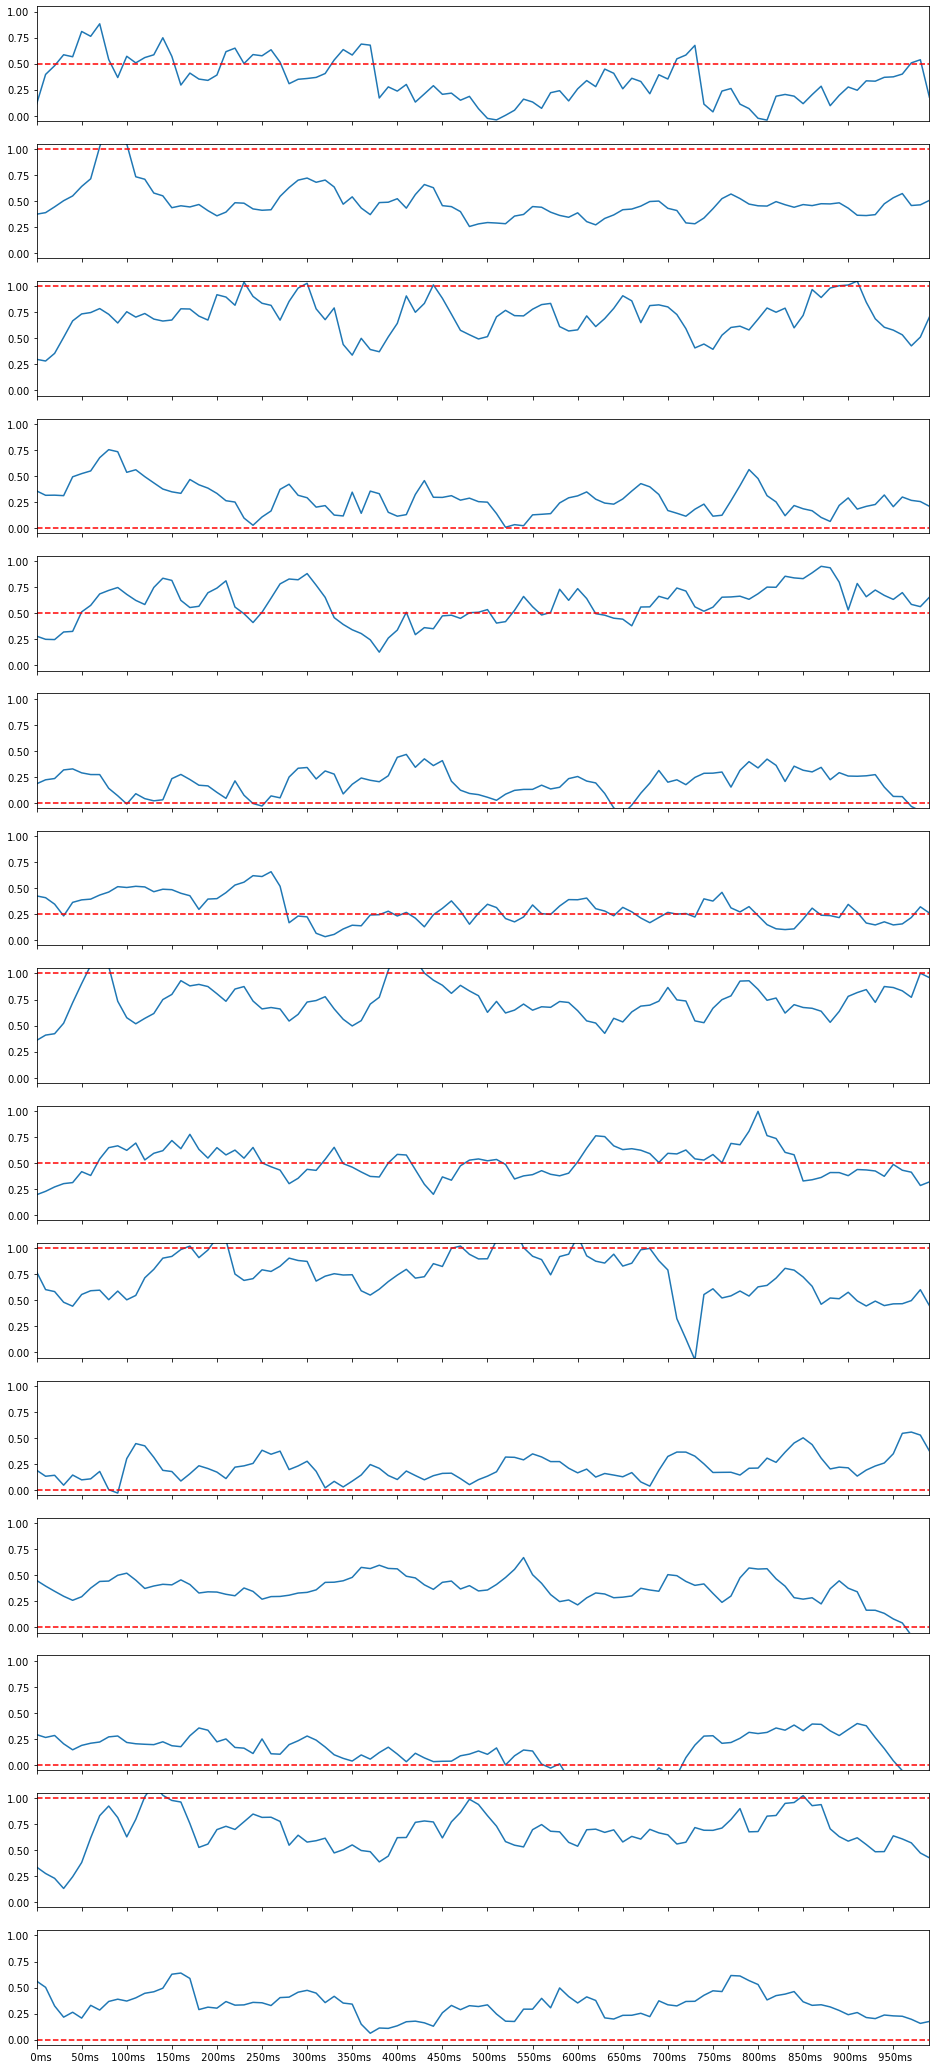

In [34]:
from sklearn.linear_model import Ridge
%matplotlib inline

X_reg = get_spikes(
    SESSION,
    SELECTOR["NEURON_VISUAL"],
    CHOSEN_TRIALS,
    (0, 100),
    align=50,
    baseline_bins=(30,50),
    smoothing=(17, 2.5),
)
NUM_BINS_REG = X_reg.shape[2]
y_reg = np.repeat(classes, NUM_BINS_REG)
X_reg = reshape_by_bins(X_reg)

reg = Ridge()
reg.fit(X_reg, y_reg)

plotted_trials = 15
xticks = np.arange(NUM_BINS_REG // 5) * 5
xticklabels = [f"{i*10:4d}ms" for i in xticks]
fig, axes = plt.subplots(plotted_trials, 1, sharex=True)
fig.set_size_inches(16, 2.5 * plotted_trials)

for trial_num in range(plotted_trials):
    y_true = classes[trial_num]
    population_activity = X_reg[(trial_num*NUM_BINS_REG):((trial_num+1)*NUM_BINS_REG), :]
    y_pred = reg.predict(population_activity)
    
    ax = axes[trial_num]
    ax.plot(y_pred)
    ax.set_ylim([-0.05, 1.05])
    ax.axhline(y=y_true, color='r', linestyle='--')
    
    if trial_num != plotted_trials - 1:
        continue

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim([0, NUM_BINS_REG - 1])

plt.show()